#### Descripción del proyecto

En este trabajo desarrollaremos un modelo de Deep Learning capaz de predecir las trayectorias de ciclones y huracanes, al mismo tiempo que exploraremos la incorporación de un módulo adicional encargado de evaluar la evolución dinámica de estos fenómenos naturales.

Durante la etapa exploratoria nos centraremos exclusivamente en los datos del océano Atlántico. Para la fase de entrenamiento y validación, por su parte, emplearemos la información de ambos océanos —Atlántico y Pacífico— de forma independiente y también combinada.

##### Importación de librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

2025-05-05 12:25:41.876449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746469541.891280   53260 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746469541.895469   53260 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746469541.905862   53260 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746469541.905888   53260 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746469541.905889   53260 computation_placer.cc:177] computation placer alr

**Transformación de los datos**

Para el desarrollo del problema, primero necesitamos hacer una exploración necesaria de los datos y abordar diferentes conceptos relacionados y coorelacionados de las trayectorias de los huracanes y su comportamiento, para ello necesitamos poder usar los datos de una manera mas cómoda, por ello se hace la transformación de la información a un formato mas aceptable.

In [ ]:
docs={
    "pacifico": "../database/pacifico-1949-2024.txt",
    "atlantico": "../database/atlantico-1851-2024.txt"
}

records=[]
with open(docs["atlantico"], 'r') as f:
    storm_id=None
    storm_name=None

    for line in f:
        parts=[p.strip() for p in line.strip().split(',')]
        
        if parts[0].startswith(('AL','EP')) and len(parts) >= 3:
            storm_id=parts[0]
            storm_name=parts[1]
            continue
        
        if storm_id and len(parts) >= 8:
            date_str=parts[0]   
            time_str=parts[1]   
            status=parts[3]   
            
            year=int(date_str[0:4])
            month=int(date_str[4:6])
            day=int(date_str[6:8])
            hour=int(time_str[0:2])
            
            lat=float(parts[4][:-1])
            lon=float(parts[5][:-1])*(-1 if parts[5].endswith('W') else 1)
            
            wind_knots=int(parts[6])
            pressure_str = parts[7].strip()
            if pressure_str in ("-999", "0", ""):
                pressure_mb = None
            else:
                try:
                    pressure_mb = int(pressure_str)
                except ValueError:
                    pressure_mb = None

            records.append({
                'storm_id':   storm_id,
                'name':       storm_name,
                'year':       year,
                'month':      month,
                'day':        day,
                'hour':       hour,
                'status':     status,
                'lat':        lat,
                'lon':        lon,
                'wind_knots': wind_knots,
                'pressure_mb':pressure_mb
            })

Hacemos el guardado de la información formateada en un csv

In [ ]:
df=pd.DataFrame(records)
df['datetime']=pd.to_datetime(df[['year','month','day','hour']].apply(
    lambda r: f"{r['year']:04d}-{r['month']:02d}-{r['day']:02d} {r['hour']:02d}:00", axis=1
))

df = df.dropna(subset=["pressure_mb"])
df = df[df["pressure_mb"] > 0]

df.to_csv('../database/atlantico.csv', index=False)

**Exploración y visualización de los datos**

Usaremos de partida una imagen general de los fenómenos os (trayectorias) detectados en el año 2023

![Trayectorias Huracanes 2023](../assets/tracks-at-2023.png)

Con ello como partida procedemos a hacer algunos plots informativos de a estructura y el comportamiento de NIGEL que corresponde al Huracán con ID "AL152023".

Podemos hacer un print de los IDs únicos para un mejor despliegue de la información en general.

In [4]:
print(df["storm_id"].unique())
storm_id_example='AL152023'
storm=df[df['storm_id']== storm_id_example]

['AL011852' 'AL031853' 'AL031854' ... 'AL172024' 'AL182024' 'AL192024']


En el siguiente plot podemos ver la evolución de la trayectoria del fenómeno natural, se le cataloga como fenómeno natural ya que a lo largo de su trayectoria el fenómeno evoluciona de Tormenta tropical hasta Huracán, siendo los punto amarillos donde toma mayor peligrosidad.

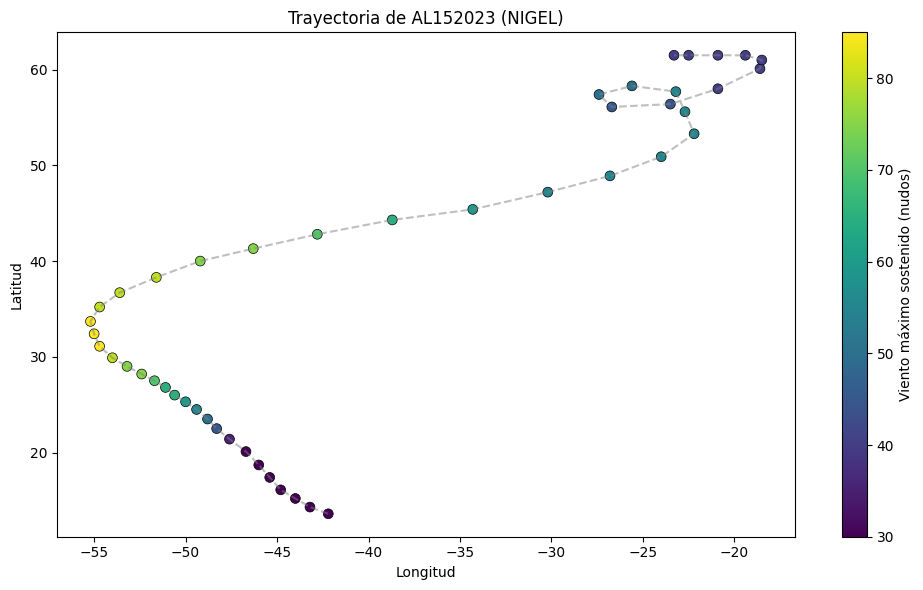

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(storm['lon'], storm['lat'], color='gray', linestyle='--', alpha=0.5)

sc=plt.scatter(
    storm['lon'], 
    storm['lat'], 
    c=storm['wind_knots'],  
    cmap='viridis',          
    s=50,                    
    edgecolor='black',       
    linewidth=0.5
)

plt.colorbar(sc, label='Viento máximo sostenido (nudos)')
plt.title(f'Trayectoria de {storm_id_example} ({storm["name"].iloc[0]})')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.style.use('ggplot')  
plt.tight_layout()

En el siguiente gráfico la distribución de velocidades de viento máximas de huracanes en un histograma con bins de 10 nudos. Se destacan estadísticas clave como la media y el percentil 75, se aplica un degradado de color según la frecuencia de cada bin, y se marca la región correspondiente a huracanes.

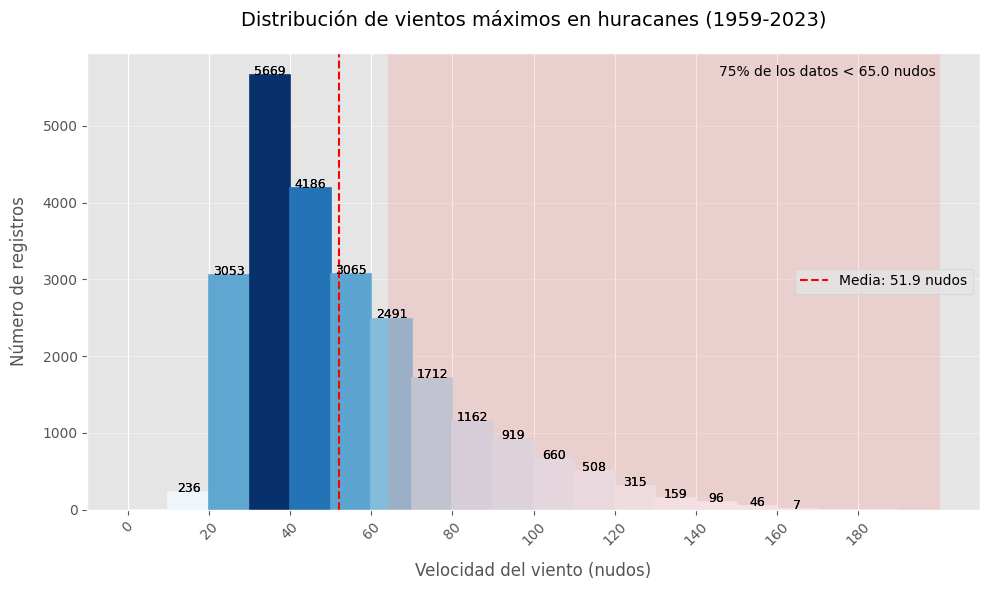

In [6]:
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df['wind_knots'], 
                           bins=range(0, 200, 10), 
                           color='skyblue',
                           edgecolor='navy',
                           linewidth=1.2)


mean_wind = df['wind_knots'].mean()
plt.axvline(mean_wind, color='red', linestyle='--', label=f'Media: {mean_wind:.1f} nudos')


plt.text(0.95, 0.95, 
         f"75% de los datos < {np.percentile(df['wind_knots'], 75):.1f} nudos",
         transform=plt.gca().transAxes,
         ha='right',
         fontsize=10)

plt.legend()

max_freq = max(n)
for i in range(len(patches)):
    plt.setp(patches[i], 
            color=plt.cm.Blues(n[i]/max_freq))  


plt.title('Distribución de vientos máximos en huracanes (1959-2023)', 
         fontsize=14, 
         pad=20)
plt.xlabel('Velocidad del viento (nudos)', fontsize=12, labelpad=10)
plt.ylabel('Número de registros', fontsize=12, labelpad=10)
plt.xticks(range(0, 200, 20), rotation=45)
plt.grid(axis='y', alpha=0.4)


plt.axvspan(64, 200, color='salmon', alpha=0.2, label='Huracanes ≥ Cat.1')

for i in range(len(patches)):
    if n[i] > 0:
        plt.text(bins[i]+5, n[i]+0.5, 
                f'{int(n[i])}', 
                ha='center', 
                fontsize=9)
        

for i in range(len(patches)):
    if n[i] > 0:
        plt.text(bins[i]+5, n[i]+0.5, 
                f'{int(n[i])}', 
                ha='center', 
                fontsize=9)
        
plt.style.use('ggplot')  
plt.tight_layout()

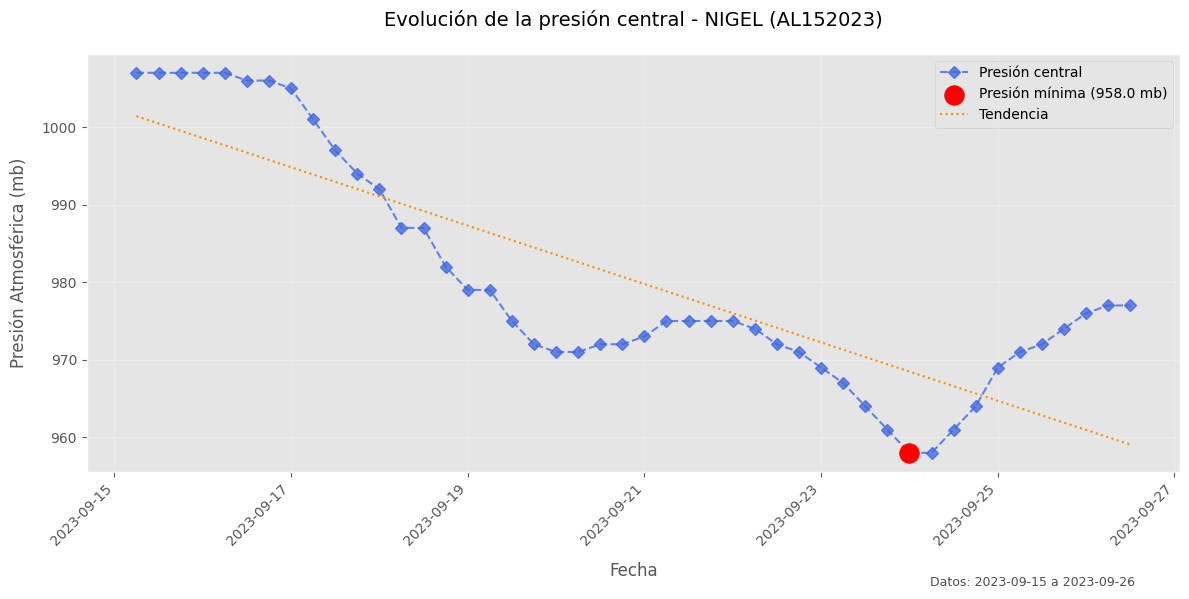

In [ ]:
plt.figure(figsize=(12, 6))


plt.style.use('ggplot')


line = plt.plot(storm['datetime'], storm['pressure_mb'], 
                marker='D',  
                markersize=6,
                linestyle='--',
                color='royalblue',
                alpha=0.8,
                label='Presión central')


min_pressure = storm['pressure_mb'].min()
min_idx = storm['pressure_mb'].idxmin()
plt.scatter(storm['datetime'].loc[min_idx], min_pressure, 
            s=200, color='red', zorder=5,
            label=f'Presión mínima ({min_pressure} mb)')


z = np.polyfit(range(len(storm)), storm['pressure_mb'], 1)
p = np.poly1d(z)
plt.plot(storm['datetime'], p(range(len(storm))), 
         color='darkorange', 
         linestyle=':',
         label='Tendencia')


plt.title(f'Evolución de la presión central - {storm["name"].iloc[0]} ({storm_id_example})', 
         fontsize=14, pad=20)
plt.xlabel('Fecha', fontsize=12, labelpad=10)
plt.ylabel('Presión Atmosférica (mb)', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)


plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', frameon=True)
plt.tight_layout()


plt.figtext(0.95, 0.01, f"Datos: {storm['datetime'].min().date()} a {storm['datetime'].max().date()}",
           ha='right', va='bottom', fontsize=9, alpha=0.7)

plt.show()

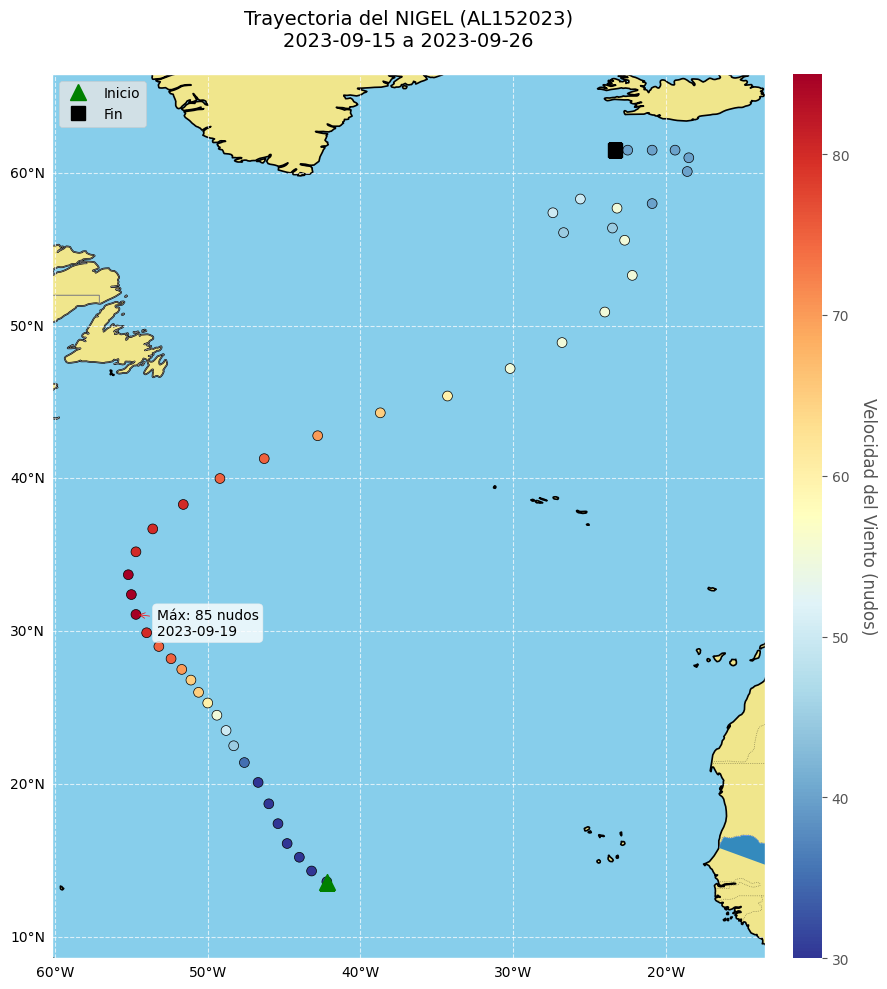

In [ ]:
plt.figure(figsize=(14, 10))
plt.style.use('ggplot')

proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.set_extent([storm['lon'].min()-5, storm['lon'].max()+5, 
              storm['lat'].min()-5, storm['lat'].max()+5], crs=proj)

ax.add_feature(cfeature.LAND, facecolor='#f0e68c', zorder=1)
ax.add_feature(cfeature.OCEAN, facecolor='#87ceeb')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.2)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='gray')

gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
gl.top_labels = False 
gl.right_labels = False 

sc = ax.scatter(storm['lon'], storm['lat'], 
               c=storm['wind_knots'], 
               cmap='RdYlBu_r', 
               s=50, 
               edgecolor='k',
               linewidth=0.5,
               transform=proj,
               zorder=3)

start_point = storm.iloc[0]
end_point = storm.iloc[-1]
ax.plot(start_point['lon'], start_point['lat'], '^', color='green', 
        markersize=12, label='Inicio', transform=proj, zorder=4)
ax.plot(end_point['lon'], end_point['lat'], 's', color='black', 
        markersize=10, label='Fin', transform=proj, zorder=4)

max_wind = storm.loc[storm['wind_knots'].idxmax()]
ax.annotate(f'Máx: {max_wind["wind_knots"]} nudos\n{max_wind["datetime"].strftime("%Y-%m-%d")}',
            xy=(max_wind['lon'], max_wind['lat']),
            xytext=(15, -15),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='red'),
            bbox=dict(boxstyle="round", fc="white", alpha=0.8))

plt.title(f'Trayectoria del {storm["name"].iloc[0]} ({storm_id_example})\n'
         f'{storm["datetime"].min().strftime("%Y-%m-%d")} a {storm["datetime"].max().strftime("%Y-%m-%d")}',
         fontsize=14, pad=20)

cbar = plt.colorbar(sc, orientation='vertical', pad=0.02, aspect=30)
cbar.set_label('Velocidad del Viento (nudos)', rotation=270, labelpad=20)
cbar.outline.set_visible(False)

plt.legend(loc='upper left', frameon=True, framealpha=0.8)

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m'),
              edgecolor='#6495ED', linewidth=0.3)

plt.tight_layout()
plt.show()

#### Creación de modelos

En esta etapa diseñaremos dos componentes especializados para abordar el problema de la forma más efectiva. El primer modelo estará basado en una arquitectura LSTM enfocada en la estimación de la trayectoria de la tormenta, utilizando como variables de entrada la presión atmosférica y la velocidad del fenómeno para predecir sus coordenadas geográficas. El segundo modelo empleará también redes LSTM y se centrará en la predicción de la presión y la velocidad, aprovechando la totalidad de los campos disponibles en el conjunto de datos para capturar las interdependencias entre todas las variables climatológicas.

#### Predicción de coordenadas

El modelo de predicción de coordenadas se implementará mediante una red LSTM capaz de procesar series temporales de presión y velocidad. Este modelo recibirá como secuencia de entrada los valores históricos de presión y velocidad de la tormenta y generará como salida las coordenadas esperadas en el siguiente paso temporal. Para mejorar la precisión, se incorporarán capas de atención que permitan al modelo concentrarse en los instantes más críticos del desarrollo del fenómeno.

In [ ]:
df = pd.read_csv("../database/atlantico.csv")

features = df[["lat", "lon", "wind_knots", "pressure_mb", "hour", "month"]].copy()
target = df[["lat", "lon"]].shift(-1).dropna()
features = features.iloc[:-1]

features["hour_sin"] = np.sin(2 * np.pi * features["hour"] / 24)
features["hour_cos"] = np.cos(2 * np.pi * features["hour"] / 24)
features["month_sin"] = np.sin(2 * np.pi * features["month"] / 12)
features["month_cos"] = np.cos(2 * np.pi * features["month"] / 12)
features.drop(["hour", "month"], axis=1, inplace=True)


scaler = RobustScaler(quantile_range=(5, 95))  
scaled_features = scaler.fit_transform(features)

In [10]:
def create_sequences(data, target, window=6):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(target[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, target.values)

In [24]:
model = Sequential()
model.add(LSTM(64, activation="tanh", return_sequences=True, 
               kernel_regularizer=L1L2(0.01, 0.01),
               input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32, activation="tanh", kernel_regularizer=L1L2(0.01, 0.01)))
model.add(Dense(32, activation="relu"))
model.add(Dense(2))

optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss="mse", metrics=['mae'])
model.fit(X, y, epochs=50, validation_split=0.2, batch_size=32)

Epoch 1/50


/home/josafat/Documentos/hurdat2-model/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.3218 - mae: 0.4458 - val_loss: 0.2164 - val_mae: 0.2885
Epoch 2/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2753 - mae: 0.3210 - val_loss: 0.1952 - val_mae: 0.2733
Epoch 3/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2561 - mae: 0.3060 - val_loss: 0.1723 - val_mae: 0.2470
Epoch 4/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2310 - mae: 0.2924 - val_loss: 0.1758 - val_mae: 0.2419
Epoch 5/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2377 - mae: 0.2951 - val_loss: 0.1538 - val_mae: 0.2268
Epoch 6/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2193 - mae: 0.2804 - val_loss: 0.1555 - val_mae: 0.2331
Epoch 7/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2267 - mae: 0.2855 - val_loss: 0.1462 - val_mae: 0.2279
Epoch 8/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2312 - mae: 0.2894 - val_loss: 0.1475 - val_mae: 0.2182
Epoch 9/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2155 

In [ ]:
model.save("../models/hurricane-lstm.h5")

joblib.dump(scaler, "../models/scaler_features.save")

In [ ]:
model = load_model(
    "../models/hurricane-lstm.h5",
    custom_objects={"mse": MeanSquaredError()}  
)
scaler_features = joblib.load("../models/scaler_features.save")

In [ ]:
new_data = [
    [25.1, -80.3, 45, 990, 18, 11],  
    [25.3, -80.8, 50, 985, 0, 11],    
    [25.5, -81.2, 55, 980, 6, 11],    
    [25.8, -81.7, 60, 975, 12, 11],   
    [26.1, -82.1, 65, 970, 18, 11],   
    [26.4, -82.5, 70, 965, 0, 11]     
]

new_df = pd.DataFrame(new_data, columns=["lat", "lon", "wind_knots", "pressure_mb", "hour", "month"])

new_df["hour_sin"] = np.sin(2 * np.pi * new_df["hour"] / 24)
new_df["hour_cos"] = np.cos(2 * np.pi * new_df["hour"] / 24)
new_df["month_sin"] = np.sin(2 * np.pi * new_df["month"] / 12)
new_df["month_cos"] = np.cos(2 * np.pi * new_df["month"] / 12)
new_df = new_df.drop(["hour", "month"], axis=1)

scaled_new_data = scaler_features.transform(new_df)

In [ ]:
input_sequence = scaled_new_data.reshape(1, 6, -1)  

In [ ]:
prediction_scaled = model.predict(input_sequence)  

lat_pred, lon_pred = prediction_scaled[0]
print(f"Próxima posición predicha: ({lat_pred:.2f}, {lon_pred:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Próxima posición predicha: (28.21, -83.23)


#### Predicción de presión y velocidad

El segundo modelo adoptará una arquitectura LSTM que reciba como entrada el conjunto completo de variables climatológicas disponible. La red aprenderá las relaciones temporales y espaciales entre las distintas variables para predecir de manera simultánea los siguientes valores de presión y velocidad del sistema. Asimismo, se evaluará la inclusión de técnicas de regularización y optimización de hiperparámetros para evitar sobreajuste y mejorar la robustez de las predicciones.

In [ ]:
df = pd.read_csv("../database/atlantico.csv")

features = df[["lat", "lon", "wind_knots", "pressure_mb", "hour", "month"]].copy()
target = df[["wind_knots", "pressure_mb"]].shift(-1).dropna()

features = features.iloc[:-1]

def add_cyclic_features(df):
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df.drop(["hour", "month"], axis=1)

features = add_cyclic_features(features)

scaler_features = RobustScaler()
scaled_features = scaler_features.fit_transform(features)

scaler_target = RobustScaler()
scaled_target = scaler_target.fit_transform(target)

In [ ]:
def create_sequences(data, target, window=6):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(target[i+window])  
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, scaled_target, window=6)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
n_features = X.shape[2]
wind_pressure_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True,
         kernel_regularizer=L1L2(0.01, 0.01),
         input_shape=(X.shape[1], n_features)),
    Dropout(0.3),
    LSTM(32, activation='tanh', 
         kernel_regularizer=L1L2(0.01, 0.01)),
    Dense(32, activation='relu'),
    Dense(2)  
])

optimizer = Adam(learning_rate=0.001, clipvalue=0.5)
wind_pressure_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

In [ ]:
history = wind_pressure_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
)

Epoch 1/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.3864 - mae: 0.4468 - val_loss: 0.2758 - val_mae: 0.3177
Epoch 2/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2624 - mae: 0.3057 - val_loss: 0.2521 - val_mae: 0.3087
Epoch 3/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2429 - mae: 0.2901 - val_loss: 0.2188 - val_mae: 0.2626
Epoch 4/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2233 - mae: 0.2794 - val_loss: 0.2440 - val_mae: 0.3054
Epoch 5/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2194 - mae: 0.2768 - val_loss: 0.2119 - val_mae: 0.2590
Epoch 6/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2063 - mae: 0.2657 - val_loss: 0.2226 - val_mae: 0.2799
Epoch 7/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2152 - mae: 0.2697 - val_loss: 0.2055 - val_mae: 0.2552
Epoch 8/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2088 - mae: 0.2673 - val_loss: 0.1997 - val_mae: 0.2493
Epoch 9/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - lo

In [ ]:
wind_pressure_model.save("../models/wind-pressure-model.keras")
joblib.dump(scaler_features, "../models/scaler-features-wind-pressure.save")
joblib.dump(scaler_target, "../models/scaler_target_wind_pressure.save")

['../models/scaler_target_wind_pressure.save']

In [ ]:
def predict_wind_pressure(input_sequence, model, scaler_features, scaler_target):
    
    scaled_input = scaler_features.transform(input_sequence)
    
    sequence = scaled_input.reshape(1, 6, -1)
    
    scaled_pred = model.predict(sequence)
    
    return scaler_target.inverse_transform(scaled_pred)

new_data = [
    [25.1, -80.3, 45, 990, 18, 11],  
    [25.3, -80.8, 50, 985, 0, 11],    
    [25.5, -81.2, 55, 980, 6, 11],    
    [25.8, -81.7, 60, 975, 12, 11],   
    [26.1, -82.1, 65, 970, 18, 11],   
    [26.4, -82.5, 70, 965, 0, 11]     
]

input_df = pd.DataFrame(new_data, 
    columns=["lat", "lon", "wind_knots", "pressure_mb", "hour", "month"])

processed_input = add_cyclic_features(input_df.copy())

prediction = predict_wind_pressure(processed_input, wind_pressure_model, scaler_features, scaler_target)
print(f"Predicción: Wind={prediction[0][0]:.1f} knots, Pressure={prediction[0][1]:.1f} mb")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Predicción: Wind=72.2 knots, Pressure=968.4 mb


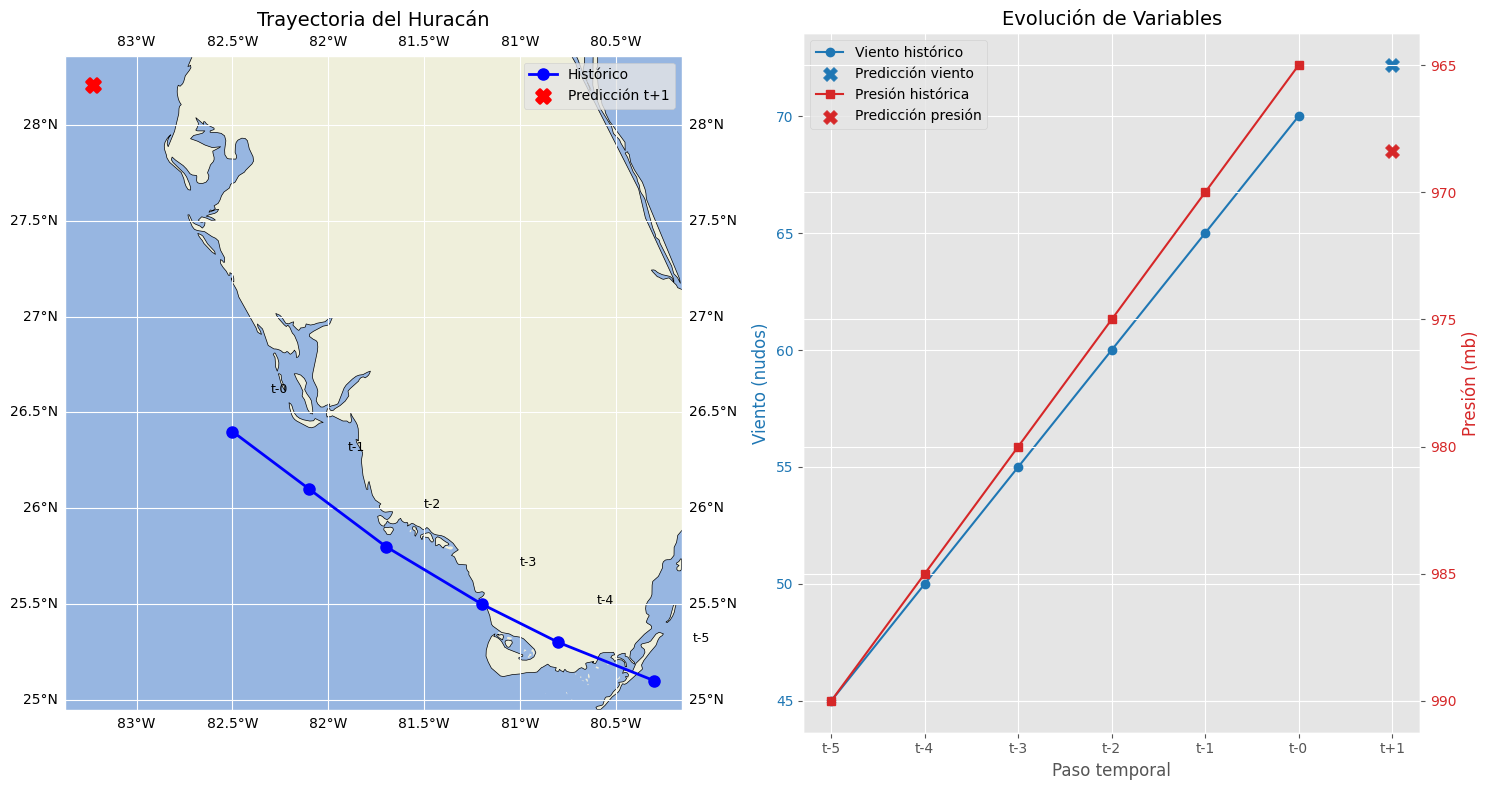

In [ ]:
historical_data = np.array(new_data)
historical_lats = historical_data[:, 0]
historical_lons = historical_data[:, 1]
historical_wind = historical_data[:, 2]
historical_pressure = historical_data[:, 3]

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_title('Trayectoria del Huracán', fontsize=14)

ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.gridlines(draw_labels=True)

ax1.plot(historical_lons, historical_lats, 
        color='blue', linewidth=2, marker='o', markersize=8,
        label='Histórico',
        transform=ccrs.PlateCarree())

ax1.scatter(lon_pred, lat_pred, 
           color='red', s=100, marker='X', linewidth=2,
           label='Predicción t+1',
           transform=ccrs.PlateCarree())

for i, (lon, lat) in enumerate(zip(historical_lons, historical_lats)):
    ax1.text(lon + 0.2, lat + 0.2, f't-{5-i}', 
            fontsize=9, transform=ccrs.PlateCarree())
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Evolución de Variables', fontsize=14)

time_steps = [f't-{5-i}' for i in range(6)] + ['t+1']
x = range(len(time_steps))

color = 'tab:blue'
ax2.set_xlabel('Paso temporal')
ax2.set_ylabel('Viento (nudos)', color=color)
ax2.plot(x[:-1], historical_wind, '-o', color=color, label='Viento histórico')
ax2.scatter(x[-1], prediction[0][0], color=color, s=100, 
           marker='X', label='Predicción viento')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xticks(x)
ax2.set_xticklabels(time_steps)

ax3 = ax2.twinx()
color = 'tab:red'
ax3.set_ylabel('Presión (mb)', color=color)
ax3.plot(x[:-1], historical_pressure, '-s', color=color, label='Presión histórica')
ax3.scatter(x[-1], prediction[0][1], color=color, s=100, 
           marker='X', label='Predicción presión')
ax3.tick_params(axis='y', labelcolor=color)
ax3.invert_yaxis()  

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

#### Conclusiones

A pesar de que los resultados obtenidos muestran valores muy bajos —indicando una efectividad mínima del modelo—, estos hallazgos son coherentes con la complejidad del problema y las limitaciones del conjunto de datos disponible. Al tratarse de fenómenos climatológicos, es fundamental incorporar variables oceánicas como la temperatura superficial del mar, las cuales no están adecuadamente representadas en el dataset actual.

En una fase de mejora futura, resulta esencial diseñar un modelo de predicción de riesgo que cuantifique tanto la probabilidad como el impacto de eventos climáticos extremos. Para ello, sería conveniente enriquecer los predictores incorporando mediciones de temperatura superficial y otros indicadores oceánicos (salinidad, corrientes), lo que debería traducirse en una mayor capacidad de generalización del modelo.

La exploración de arquitecturas avanzadas —por ejemplo, redes neuronales recurrentes o modelos basados en atención— permitiría capturar con mayor precisión la dinámica temporal y las interacciones entre las distintas variables climatológicas. Con estas mejoras se espera elevar la precisión del modelo y potenciar su aplicabilidad en estudios y sistemas de alerta temprana de fenómenos meteorológicos.